In [1]:
import os
import time
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import torch.utils.model_zoo as model_zoo
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import *
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader

In [2]:
SAVEPATH = "save/"
SPLIT_RATE = 0.9
BATCH_SIZE = 5

SAVE_EVERY = 15
DEV_EVERY = 15
LOG_EVERY = 15

In [3]:
def heatmap(y_true, y_pred, name):
    target_names = ['A',
                    'B',
                    'C',
                    'D',
                    'E',
                    'F']
    clf_cm = confusion_matrix(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred, digits=4, target_names=target_names, output_dict=True)
    clf_report2 = classification_report(y_true, y_pred, digits=4,target_names=target_names)
    print(clf_report2)

    f, ax= plt.subplots(figsize=(6,5))
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, 
                annot=True, cmap="Blues_r", fmt=".4f")
    ax.set_title("Classification Report")
    f.tight_layout()
    if os.path.isdir("plots/"):
        plt.savefig("plots/"+name+time.strftime('%H_%M_%S')+"_classification_report.jpg")
    else:
        os.mkdir("plots/")
        plt.savefig("plots/"+name+time.strftime('%H_%M_%S')+"_classification_report.jpg")
    f.clf()

    f, ax= plt.subplots(figsize=(5,5))
    #4.23及以前的图横轴True，纵轴Prediction
    sns.heatmap(pd.DataFrame(clf_cm, index=target_names, columns=target_names).T, 
                    annot=True, cmap="BuGn", fmt="d")
    ax.set_title("Confusion Matrix")
    f.tight_layout()
    plt.savefig("plots/"+name+time.strftime('%H_%M_%S')+"_confusion_matrix.jpg")
    plt.show()

In [4]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


class Basicblock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Basicblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
#         x = self.drop1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
#         x = self.drop2(x)

        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

class Resnet(nn.Module):
    def __init__(self, block, num_layer, n_classes=6, input_channels=1, name="resnet18"):
        super(Resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_layer[0])
        self.layer2 = self._make_layer(block, 128, num_layer[1], 2)
        self.layer3 = self._make_layer(block, 256, num_layer[2], 2)
        self.layer4 = self._make_layer(block, 512, num_layer[3], 2)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=3, bias=False)
        self.bn2 = nn.BatchNorm2d(512, momentum=0.9)

        self.avgpool = nn.AvgPool2d(kernel_size=9, stride=1)
        self.fc1 = nn.Linear(9*512, n_classes)
#         self.fc2 = nn.Linear(512, n_classes)
        self.softmax = nn.Softmax(dim=1)
        self.name = name
        self.drop = nn.Dropout()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def _make_layer(self, block, out_channels, num_block, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*block.expansion, momentum=0.9)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels*block.expansion
        for _ in range(1, num_block):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         print(x.shape)
        x = self.avgpool(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.fc1(x)
#         x = self.drop(x)
#         x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def _class_name(self):
        return self.name


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(Basicblock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(Basicblock, [3, 4, 6, 3], name="resnet34", **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


# def resnet50(pretrained=False, **kwargs):
#     """Constructs a ResNet-50 model.

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = Resnet(Bottleneck, [3, 4, 6, 3], name="resnet50", **kwargs)
#     if pretrained:
#         # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
#         model_path = './initmodel/resnet50_v2.pth'
#         model.load_state_dict(torch.load(model_path), strict=False)
#     return model

# def resnet101(pretrained=False, **kwargs):
#     """Constructs a ResNet-101 model.

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = Resnet(Bottleneck, [3, 4, 23, 3], name="resnet101", **kwargs)
#     if pretrained:
#         # model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
#         model_path = './initmodel/resnet101_v2.pth'
#         model.load_state_dict(torch.load(model_path), strict=False)
#     return model

# def resnet152(pretrained=False, **kwargs):
#     """Constructs a ResNet-152 model.

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = Resnet(Bottleneck, [3, 8, 36, 3], name="resnet152", **kwargs)
#     if pretrained:
#         # model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
#         model_path = './initmodel/resnet152_v2.pth'
#         model.load_state_dict(torch.load(model_path), strict=False)
#     return model

In [5]:
# Block of layers: Conv --> BatchNorm --> ReLU --> Pool
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_mode='max'):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.drop = nn.Dropout(0.25)
        self.bn = nn.BatchNorm2d(out_channels, momentum = 0.9)
        self.relu = nn.ReLU()
        if pool_mode == "max":
            self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        else:
            self.pool = nn.AvgPool2d(3, stride=1)
            

    def forward(self, input):
        x = self.conv(input)
#         x = self.drop(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x
        

class DeepNet(nn.Module):
    def __init__(self, n_classes=6, input_channels=1):
        super(DeepNet, self).__init__()
        self.convb1 = ConvBlock(input_channels, 64, 'max')
        self.convb2 = ConvBlock(64, 64, 'max')
        self.convb3 = ConvBlock(64, 128, 'max')
        self.convb4 = ConvBlock(128, 128, 'avg')
#         self.convb5 = ConvBlock(128, 256, 'max')
#         self.convb6 = ConvBlock(256, 256, 'avg')
        self.fc1 = nn.Linear(6272, 512)
        self.drop = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, n_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def _class_name(self):
        return "DeepNet"
    
    def forward(self, input):
        x = self.convb1(input)
        x = self.convb2(x)
        x = self.convb3(x)
        x = self.convb4(x)
#         x = self.convb5(x)
#         x = self.convb6(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [6]:
class DealDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = x_data.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

def data_loader(data_X, data_y):
    data = DealDataset(data_X, data_y)
    size = data.len
    loader = DataLoader(dataset=data,           
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    num_workers=2)
    return loader

def checkpoint(net, save_path, acc, loss, iterations):
    snapshot_prefix = os.path.join(save_path, 'snapshot_' + net._class_name())
    snapshot_path = snapshot_prefix + '_acc_{:.2f}_loss_{:.4f}_iter_{}_model.pt'.format(acc, loss, iterations)
    torch.save(net, snapshot_path)
    for f in glob.glob(snapshot_prefix + '*'):
        if f != snapshot_path:
            os.remove(f)

def train(optimizer, criterion, net, device, epoches, save_path=SAVEPATH):
    iterations = 0
    start = time.time()
    
    best_dev_acc = -1; best_snapshot_path = ''
    header = '  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy'
    dev_log_template = ' '.join('{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.1f}%,{:>7.4f},{:8.4f},{:12.4f}%,{:12.4f}%'.split(','))
    log_template = ' '.join('{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.1f}%,{:>7.4f},{},{:12.4f}%,{}'.split(','))
    
    if os.path.isdir(save_path) == False:
        os.makedirs(save_path)
    print(header)

    train_loader = data_loader(np.load("X_train_p.npy"), np.load("y_train_p.npy"))
    dev_loader = data_loader(np.load("X_test_p.npy"), np.load("y_test_p.npy"))
    
    records = {'acc':[],'dev_acc':[], 'loss':[], 'dev_loss':[]}

    for epoch in range(epoches):  # loop over the dataset multiple times
        correct, total, print_loss, n= 0, 0, 0, 0
        for i, data in enumerate(train_loader, 0):
            iterations += 1
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float()) 
            
            total += labels.size(0)
            labels = labels.argmax(dim=1)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            
            
            loss = criterion(outputs, labels)
            print_loss += loss.item()
            loss.backward()
            optimizer.step()  
        
            # compute accuracy 
            acc = correct / total * 100
        
            # checkpoint model periodically
            if iterations % SAVE_EVERY == 0:
                checkpoint(net, save_path, acc, print_loss/n, iterations)
            
            # validation model periodically
            if iterations % DEV_EVERY == 0:
                # calculate accuracy on validation set
                dev_correct, dev_total, dev_loss , m = 0, 0, 0, 0
                net.eval()
                with torch.no_grad():
                    for dev_batch_idx, dev_batch in enumerate(dev_loader, 0):
                        signals, labels = dev_batch
                        signals = signals.to(device)
                        labels = labels.to(device)
                        
                        predicts = net(signals.float())
                        labels = labels.argmax(dim=1)
                        dev_loss += criterion(predicts, labels).item()
                        dev_correct += (torch.max(predicts, 1)[1].view(-1) == labels).sum().item()
                        dev_total += labels.size(0)
                        m += 1
                dev_acc = 100. * dev_correct / dev_total

                print(dev_log_template.format(time.time()-start,
                    epoch, iterations, 1+i, len(train_loader),
                    100. * (1+i) / len(train_loader), print_loss/n, dev_loss/m, acc, dev_acc))
                
                records['acc'].append(acc)
                records['dev_acc'].append(dev_acc)
                records['loss'].append(print_loss/n)
                records['dev_loss'].append(dev_loss/m)

                # update best valiation set accuracy
                if dev_acc >= best_dev_acc:

                    # found a model with better validation set accuracy

                    best_dev_acc = dev_acc
                    snapshot_prefix = os.path.join(save_path, 'best_snapshot_' + net._class_name())
                    best_snapshot_path = snapshot_prefix + '_devacc_{:.2f}_devloss_{:.4f}__iter_{}_model.pt'.format(dev_acc, dev_loss/m, iterations)

                    # save model, delete previous 'best_snapshot' files
                    torch.save(net, best_snapshot_path)
                    for f in glob.glob(snapshot_prefix + '*'):
                        if f != best_snapshot_path:
                            os.remove(f)
                net.train()

            elif iterations % LOG_EVERY == 0:
                # print progress message
                print(log_template.format(time.time()-start,
                    epoch, iterations, 1+i, len(train_loader),
                    100. * (1+i) / len(train_loader), print_loss/n, ' '*8, acc, ' '*12))
            n += 1
    print('Finished Training')
    return net, best_snapshot_path, records

def test(net, device):
    correct = 0
    total = 0
    
    test_loader = data_loader(np.load("X_test_p.npy"), np.load("y_test_p.npy"))
    y_pred = []
    y_true = []
    
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            signals, labels = data
            signals = signals.to(device)
            labels = labels.to(device)
            labels = labels.argmax(dim=1)
            for i in labels.view(-1):
                y_true.append(i.view(-1).tolist())
            
            outputs = net(signals.float())
            predicted = outputs.data.argmax(dim=1)
            for i in predicted.view(-1) :
                y_pred.append(i.view(-1).tolist())
            
            labels = labels.view(-1)
            correct += (predicted.view(-1) == labels).sum().item()
            total += labels.size(0)
    
    acc = 100 * correct / total
    print(total,correct)
    print('Accuracy: %.2f %%' % acc)
    return acc, np.ravel(y_true), np.ravel(y_pred)

Using GPU for training
  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy
     8     0        15    15/15      100.0%  1.9560   1.7213      18.9189%      26.3158%
    16     1        30    15/15      100.0%  1.8983   1.7063      25.6757%      31.5789%
    24     2        45    15/15      100.0%  1.8351   1.7574      32.4324%      21.0526%
    31     3        60    15/15      100.0%  1.7469   1.5594      44.5946%      47.3684%
    39     4        75    15/15      100.0%  1.7012   1.5418      47.2973%      52.6316%
    47     5        90    15/15      100.0%  1.5774   1.4972      60.8108%      57.8947%
    55     6       105    15/15      100.0%  1.5328   1.5445      70.2703%      52.6316%
    62     7       120    15/15      100.0%  1.4993   1.4089      68.9189%      63.1579%
    71     8       135    15/15      100.0%  1.4543   1.4478      72.9730%      57.8947%
    78     9       150    15/15      100.0%  1.3690   1.3883      81.0811%      63.1579

<Figure size 432x360 with 0 Axes>

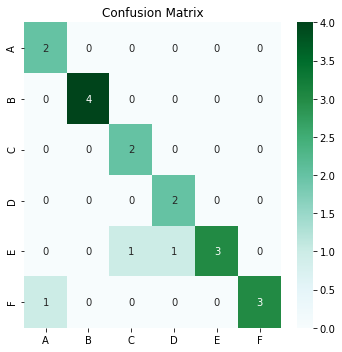

In [7]:
if __name__ == "__main__":
    if torch.cuda.is_available():
        torch.cuda.set_device(1)
        device = torch.device('cuda:{}'.format(1))
        print("Using GPU for training")
    else:
        device = torch.device('cpu')
        
    net = resnet34().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.00005, weight_decay=1e-8)
    criterion = nn.CrossEntropyLoss()
    net, fp, records = train(optimizer, criterion, net, device, 30)
    np.save("records_resnet34_p", records)
#     net = torch.load("save/best_snapshot_DeepNet_devacc_63.16_devloss_1.5753__iter_225_model.pt")
    net = torch.load(fp)
    acc, y_true, y_pred = test(net, device)
    heatmap(y_true, y_pred, "RESNET34P")
    

In [8]:
filepath = "data/maestro-v3.0.0_modify.csv"
data = pd.read_csv(filepath)
# Subset for  composer identification
# data.drop_duplicates("canonical_title",keep = False, inplace = True)
# counts = data["canonical_composer"].value_counts()
# selected_composers = counts[counts >= 50].index #24
# selected_composers = np.asarray(selected_composers)
# selection = pd.DataFrame(columns=data.columns)
# for i in selected_composers:
#     choices = data[data["canonical_composer"] == i].head(60)
#     selection = pd.concat([selection, choices], ignore_index=True)
# selection.to_csv("data/composer_selection.csv", index=False)
# # Subset for performer identificaion
counts = data["performer"].value_counts()
selected_performers = counts[counts >= 10].index #24
selected_performers = np.asarray(selected_performers)
selection = pd.DataFrame(columns=data.columns)
for i in selected_performers:
    choices = data[data["performer"] == i]
    selection = pd.concat([selection, choices], ignore_index=True)
selection.to_csv("data/performer_selection.csv")

# Johann Sebastian Bach,"Prelude and Fugue in C sharp major, WTC I, BWV 848",
#train,2011,2011/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_08_Track08_wav.midi,
#2011/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_08_Track08_wav.wav,202.54920984400002,
#Vivian Lou,Canada,174,386


In [9]:
# import librosa.display
# wav, fs = librosa.load("/import/c4dm-datasets/maestro-v2.0.0/2011/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_08_Track08_wav.wav", sr=44100, offset=0, duration=500)
# mel = librosa.feature.melspectrogram(wav, 
#                                     sr=fs, 
#                                     hop_length=1024,
#                                     win_length=2048,
#                                     n_fft=2048,
#                                     n_mels=64, 
#                                     fmax =8000)
# fig, ax = plt.subplots()
# S_dB = librosa.power_to_db(mel, ref=np.max)
# img = librosa.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=fs,
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
# plt.savefig("sample_plot.png")


# 